In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import transitleastsquares as tls
from astropy.timeseries import LombScargle
from scipy.stats import median_absolute_deviation as median_abs_deviation

import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
from celerite2.theano import terms, GaussianProcess

In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
targets = ['WASP-6', 'WASP-96']#['WASP-25','WASP-6', 'WASP-55','WASP-96','WASP-124','HATS-29']
for target in targets:
    sr = lk.search_lightcurvefile(target, mission='TESS')
    print(sr)

SearchResult containing 3 data products.

 #   observation   target_name                       productFilename                        distance
--- -------------- ----------- ------------------------------------------------------------ --------
  0  TESS Sector 2   204376737      tess2018234235059-s0002-0000000204376737-0121-s_lc.fits      0.0
  1 TESS Sector 29   204376737 tess2020238165205-s0029-0000000204376737-0193-a_fast-lc.fits      0.0
  2 TESS Sector 29   204376737      tess2020238165205-s0029-0000000204376737-0193-s_lc.fits      0.0
SearchResult containing 3 data products.

 #   observation   target_name                       productFilename                        distance
--- -------------- ----------- ------------------------------------------------------------ --------
  0  TESS Sector 2   160148385      tess2018234235059-s0002-0000000160148385-0121-s_lc.fits      0.0
  1 TESS Sector 29   160148385 tess2020238165205-s0029-0000000160148385-0193-a_fast-lc.fits      0.0
  2 TES

In [4]:
def get_tess_lc(target, PLOT =True, obs=0):
    #obs==if target has been obseerved more than once, specify which observation you want to analize
    sr = lk.search_lightcurvefile(target, mission='TESS')[obs]
    lcfs = sr.download_all()
    lc0 = lcfs.PDCSAP_FLUX.stitch().remove_nans()
    if PLOT:
        lc0.errorbar(marker='.', alpha=0.5)
        plt.savefig(f'{target}_tess_lc.pdf', bbox_inches='tight')
        plt.show()
        plt.close()
    return lc0

 WASP6 


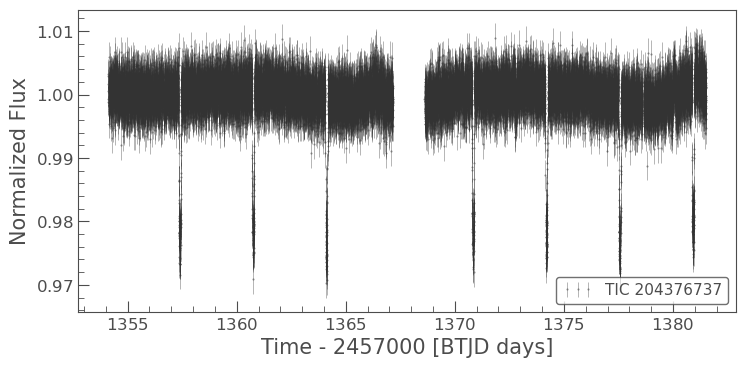

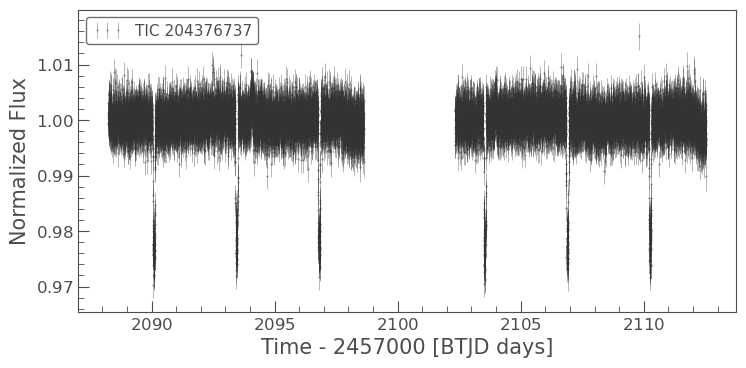

In [15]:
target = 'WASP-6'
print ('\033[1m WASP6 \033[0m')
W6lc_epc1 = get_tess_lc(target, PLOT=True, obs=0)
W6lc_epc2 = get_tess_lc(target, PLOT=True, obs=2)

 WASP96 


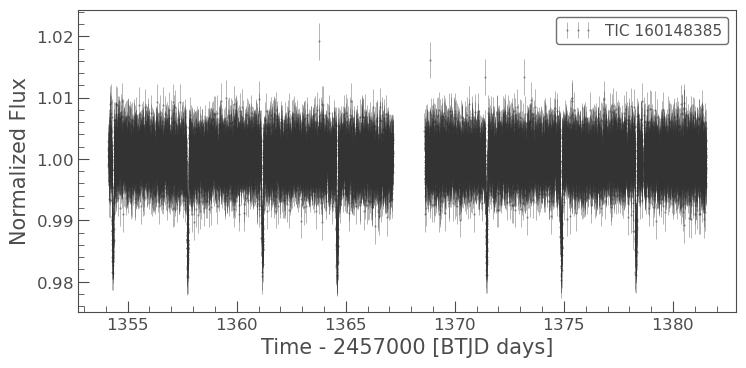

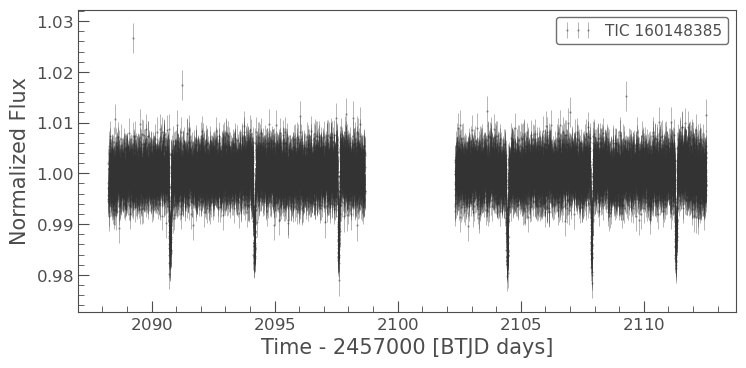

In [13]:
target = 'WASP-96'
print ('\033[1m WASP96 \033[0m')
W96lc_epc1 = get_tess_lc(target, PLOT=True, obs=0)
W96lc_epc2 = get_tess_lc(target, PLOT=True, obs=2)

In [8]:
def mask_transits(lc0, t0, p, d, PLOT = True):
    intransit = tls.transit_mask(lc0.time, p, d, t0)
    lc = lc0[~intransit]
    if PLOT:
        lc.errorbar(marker='.', alpha=0.5)
        plt.savefig(f'{target}_tess_lc_transits_masked.pdf', bbox_inches='tight')
        plt.show()
        plt.close()
    return lc

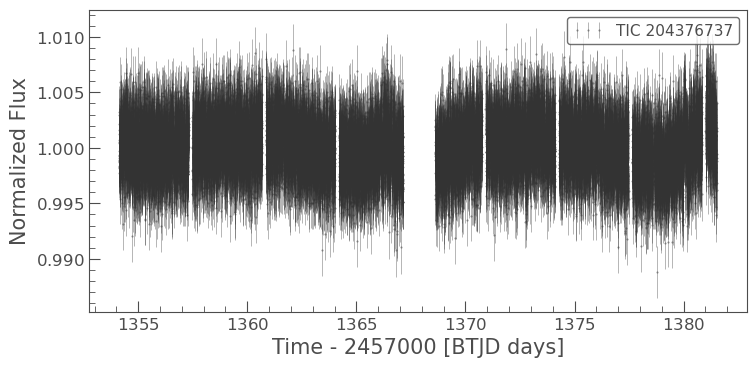

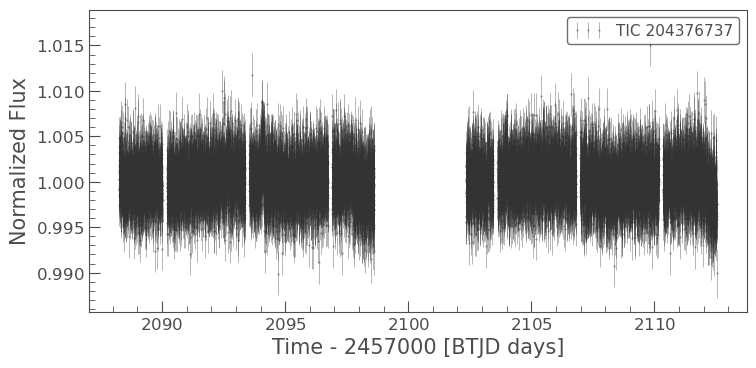

In [16]:
#W25
# t0 = 1572.990723
# p = 3.764873
# d = 1.5*2.759996/24.

#W6
t0 = 1357.394531 #2090.097109 for 2nd TESS observation
p = 3.361021
d = 1.5*2.579176/24.

lc_OOT1 = mask_transits(W6lc_epc1, t0, p, d, PLOT = True)
lc_OOT2 = mask_transits(W6lc_epc2, 2090.097109, p, d, PLOT = True)

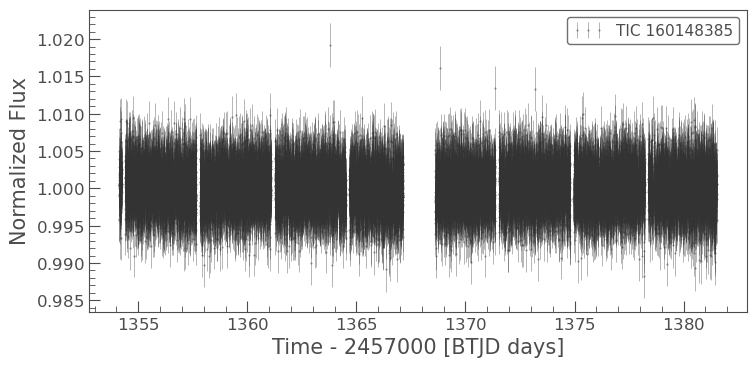

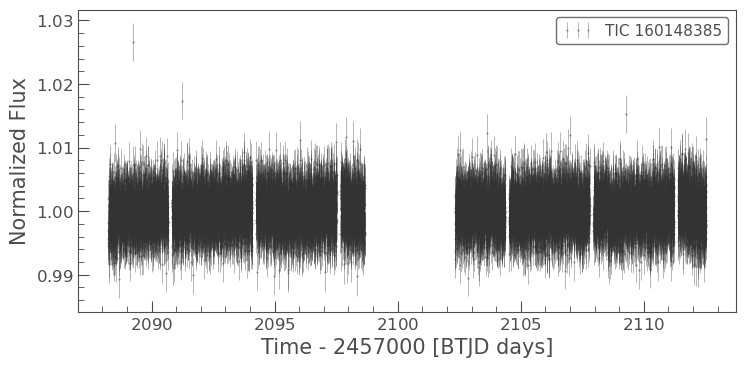

In [17]:
#W96
t0 = 1354.319946
p = 3.425239
d = 1.5*2.44683/24.

lc_OOT1 = mask_transits(W96lc_epc1, t0, p, d, PLOT = True)
lc_OOT2 = mask_transits(W96lc_epc2, t0, p, d, PLOT = True)

In [20]:
print("std of W6", np.std(np.concatenate((W6lc_epc1.flux, W6lc_epc2.flux)))*1e6)
print("std of W96", np.std(np.concatenate((W96lc_epc1.flux, W96lc_epc2.flux)))*1e6)

std of W6 4165.41937738657
std of W96 3427.1355252712965


In [12]:
def weighted_avg_and_std(values, weights):
    """ Return the weighted average and standard deviation. values, weights -- Numpy ndarrays with the same shape."""
    average = np.average(values, weights=weights) #weights = 1./err_bar^2. Where err_bar=std & err_bar^2 = variance
    variance = np.average((values-average)**2, weights=weights) # Fast and numerically precise
    return average, np.sqrt(variance)

def BinDat(time, LC, LC_err, Bin=100):
    """Method to bin the data, using the weighted mean of a given databin size 'Bin.' The error is estimated using the
    technique discussed here https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy"""
    Remainder = len(LC)%Bin
    LenSplit = int(np.trunc(len(LC)/Bin))
    if Remainder > 0: #To collect remainders for the last bin
        Main, mainErr, mainT= LC[:len(LC)-Remainder], LC_err[:len(LC_err)-Remainder], time[:len(time)-Remainder]
        Remain, RemainErr, remainT= LC[len(LC)-Remainder:], LC_err[len(LC_err)-Remainder:], time[len(time)-Remainder:]
        size = LenSplit+1
    else:
        Main, mainErr, mainT = LC, LC_err, time
        size = LenSplit
    BinLC, BinLCerr, BinT = np.zeros(size), np.zeros(size), np.zeros(size)
    Splits, splitErr, splitT = np.split(Main, LenSplit), np.split(mainErr, LenSplit), np.split(mainT, LenSplit)
    if Remainder: 
        Splits.append(Remain), splitErr.append(RemainErr), splitT.append(remainT)
    for S in range(len(Splits)):
        Avg, Err = weighted_avg_and_std(Splits[S], 1/(splitErr[S]**2)) #weight = 1/variance = 1/sig^2 = 1/err_bar^2
        BinLC[S], BinLCerr[S], BinT[S] = Avg, Err, np.mean(splitT[S])
    return BinLC, BinLCerr, BinT

# def BinDat_std(time, LC, Bin=100):
#     Remainder = len(LC)%Bin
#     LenSplit = int(np.trunc(len(LC)/Bin))
#     if Remainder > 0: #To collect remainders for the last bin
#         Main, mainT= LC[:len(LC)-Remainder], time[:len(time)-Remainder]
#         Remain, remainT= LC[len(LC)-Remainder:], time[len(time)-Remainder:]
#         size = LenSplit+1
#     else:
#         Main, mainT = LC, time
#         size = LenSplit
#     BinLC, BinLCerr, BinT = np.zeros(size), np.zeros(size), np.zeros(size)
#     Splits, splitT = np.split(Main, LenSplit), np.split(mainT, LenSplit)
#     if Remainder > 0:
#         Splits.append(Remain), splitT.append(remainT)
#     for S in range(len(Splits)):
#         BinLC[S], BinLCerr[S], BinT[S] = np.mean(Splits[S]), np.std(Splits[S]), np.mean(splitT[S])
#     return BinLC, BinLCerr, BinT

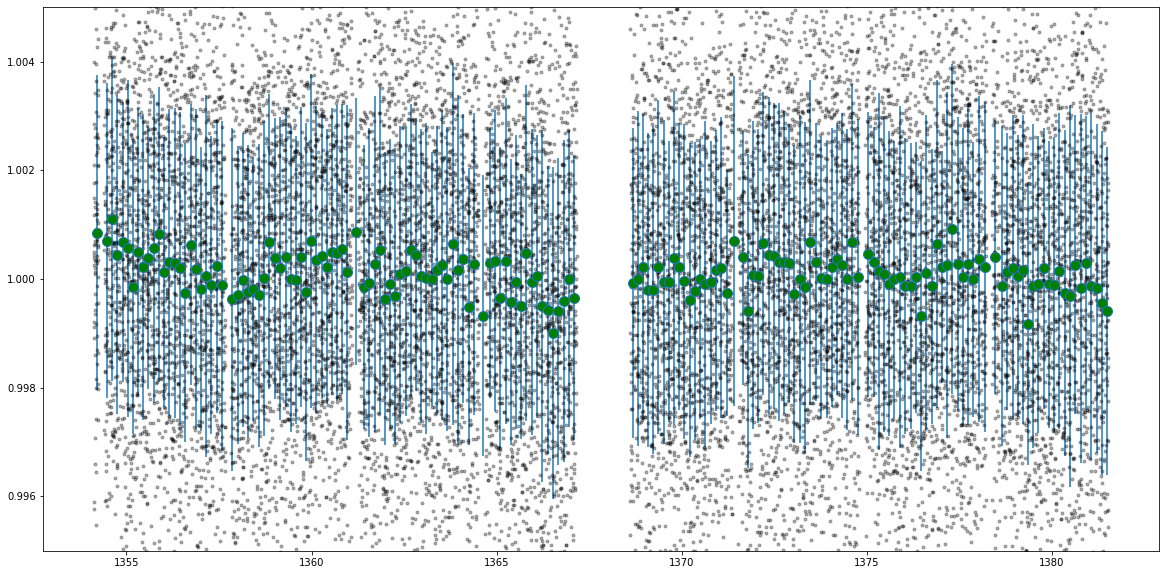

In [13]:
phase_size = 100
binned_lc = lc_OOT1.bin(phase_size)
# print ("np.mean(lc.flux_err)", np.mean(lc.flux_err))
# print ("np.mean(binned_lc.flux_err)", np.mean(binned_lc.flux_err))
plt.figure(figsize=(20, 10))
# TimerErr = np.zeros(len(lc.time))
# plt.errorbar(lc.time[::100], lc.flux[::100], [lc.flux_err[::100], lc.flux_err[::100]], [TimerErr[::100], TimerErr[::100]],'k.', markersize=6)
plt.plot(lc_OOT1.time, lc_OOT1.flux,'k.', markersize=6, alpha =.3)
# BtimerErr = np.zeros(len(binned_lc.time))
# plt.errorbar(binned_lc.time, binned_lc.flux, [binned_lc.flux_err, binned_lc.flux_err], [BtimerErr, BtimerErr],'.', markersize=10, marker='o', mfc='white')
binned_lc, binned_lc_err, binned_lc_time = BinDat(lc_OOT1.time, lc_OOT1.flux, lc_OOT1.flux_err, Bin=100)
# print ("np.mean(binned_lc_err)", np.mean(binned_lc_err))
# print ("binned_lc_time.shape:", binned_lc_time.shape, "np.mean(binned_lc_time):", np.mean(binned_lc_time))
timeErr = np.zeros(len(binned_lc_time))
plt.errorbar(binned_lc_time, binned_lc, [binned_lc_err, binned_lc_err], [timeErr, timeErr],'.', markersize=10, marker='o', mfc='green')
# binned_lc, binned_lc_err, binned_lc_time = BinDat_std(lc.time, lc.flux, Bin=100)
# print ("np.mean(binned_lc_err)", np.mean(binned_lc_err))
# plt.errorbar(binned_lc_time, binned_lc, [binned_lc_err, binned_lc_err], [timeErr, timeErr],'.', markersize=10, marker='o', mfc='orange')

plt.ylim((.9950,1.005))
plt.show()
plt.close()

In [ ]:
phase_size = 100
binned_lc = lc_OOT1.bin(phase_size)
plt.figure(figsize=(20, 10))
plt.plot(lc_OOT2.time, lc_OOT2.flux,'k.', markersize=6, alpha =.3)
binned_lc, binned_lc_err, binned_lc_time = BinDat(lc_OOT2.time, lc_OOT2.flux, lc_OOT2.flux_err, Bin=100)
timeErr = np.zeros(len(binned_lc_time))
plt.errorbar(binned_lc_time, binned_lc, [binned_lc_err, binned_lc_err], [timeErr, timeErr],'.', markersize=10, marker='o', mfc='green')
plt.ylim((.9950,1.005))
plt.show()
plt.close()

In [14]:
def analyze_periodicityBR(lc, target): #This is B.R. code which finds periodicity using a periodagram on the original TESS data
    # Look for any periodic variation
    ls = LombScargle(lc.time, lc.flux, lc.flux_err)
    frequency, power = ls.autopower(
        minimum_frequency=1./lc.time.ptp(),
        maximum_frequency=1./0.1
    )
    period = 1./frequency

    # Identify best period
    best_frequency = frequency[np.argmax(power)]
    best_period = 1./best_frequency
    fap = ls.false_alarm_probability(power.max())
    
    # Plot Lomb-Scargle results
    fig, ax = plt.subplots()

    log_probs = np.array([-2, -4, -6])
    fals = ls.false_alarm_level(10.**log_probs)

    ax.plot(period, power)
    xlim = ax.get_xlim()
    xrange = np.ptp(xlim)
    ax.axvline(best_period, alpha=0.4, lw=3)
    for n in range(2, 100):
        if n*best_period <= period.max():
            ax.axvline(n*best_period, alpha=0.4, lw=1, linestyle='--')
        if best_period/n >= period.min():
            ax.axvline(best_period/n, alpha=0.4, lw=1, linestyle='--')
    ax.text(
        best_period+0.05*xrange, power.max(), 
        f'P = {best_period:.2f} d, FAP = 10$^{{{np.log10(fap):.0f}}}$',
        va='top'
    )
    xtext = xlim[0]+0.75*xrange
    for log_prob, fal in zip(log_probs, fals):
        ax.axhline(fal, ls='--', lw=1, color='k')
        ax.text(
            xtext, fal, f'FAP = 10$^{{{log_prob}}}$',
            fontsize='12', va='bottom', transform=ax.transData
        )
    ax.set_xlabel('Period (d)')
    ax.set_ylabel('Lomb-Scargle Power')
    plt.tight_layout()
    plt.savefig(f'{target}_ls_power.pdf', bbox_inches='tight')
    plt.show()
    plt.close()    

    # Plot phase-folded light curve
    fig, axes = plt.subplots(2, figsize=(6.5, 6.5), sharex=True)
    
    phase = np.linspace(-0.5, 0.5, 100)
    phased_times = phase*best_period
    y_fit = ls.model(phased_times, best_frequency)
    amp = y_fit.ptp()

    folded_lc = lc.fold(best_period)
    binned_lc = folded_lc.bin(phase.size)

    ax = axes[0]
    ax.plot(
        folded_lc.time, folded_lc.flux, 'k.', ms=2, alpha=0.5, rasterized=True
    )
    # ax.errorbar(
    #     binned_lc.time, binned_lc.flux, binned_lc.flux_err,
    #     ls='', marker='o', mfc='white', ms=3, mew=1, zorder=10
    # )
    ax.plot(phase, y_fit, color='C1')
    ax.set_ylabel('Normalized Flux')

    flux_ppm = (folded_lc.flux-1.)*1e6
    binned_flux_ppm = (binned_lc.flux-1.)*1e6
    binned_flux_err_ppm = (binned_lc.flux_err)*1e6
    y_fit_ppm = (y_fit-1.)*1e6
#     print ('binned_flux_ppm', binned_flux_ppm)
#     print ('type(binned_flux_ppm)', type(binned_flux_ppm))
    mad = median_abs_deviation(binned_flux_ppm) #, scale='normal') - 'normal' scale doesn't work for some reason, maybe because using py3

    ax = axes[1]
    ax.plot(
        folded_lc.time, flux_ppm, 'k.', ms=2, alpha=0.2, rasterized=True
    )
    ax.errorbar(
        binned_lc.time, binned_flux_ppm, binned_flux_err_ppm,
        ls='', marker='o', mfc='white', ms=4, mew=1, zorder=10
    )
    ax.plot(phase, y_fit_ppm, color='C1', zorder=11)
    ax.set_ylim(y_fit_ppm.min()-3*mad, y_fit_ppm.max()+3*mad)
    ax.set_xlabel('Phase')
    ax.set_ylabel('Normalized Flux (ppm)')

    plt.tight_layout()
    plt.savefig(f'{target}_lc_phased.pdf', dpi=600)
    plt.show()
    plt.close()
    
    return best_period, amp, fap

In [15]:
def analyze_periodicity(lc, target, BinSize, PLOT =True, phyP = .5): #This is Chima's adaptations of B.R. code which finds periodicity using a 
    #periodagram of the binned TESS data. Doing this because of fear that high cadence of observations causes found 
    #periods to be derived from the noise in the high cadence data.
    if BinSize == None or BinSize == 0:
        binned_lc, binned_lc_err, binned_lc_time = lc.flux, lc.flux_err, lc.time
    else:  
        binned_lc, binned_lc_err, binned_lc_time = BinDat(lc.time, lc.flux, lc.flux_err, Bin=BinSize)
        
    #Look for any periodic variation
    ls = LombScargle(binned_lc_time, binned_lc, binned_lc_err)
    frequency, power = ls.autopower(minimum_frequency=1./lc.time.ptp(),maximum_frequency=1./0.1)
    period = 1./frequency
    PhysPeriods = np.where((P_Rnge[0] < period) & (period < P_Rnge[1]))[0] #only include periods within range that is physical    
    frequency, power = frequency[PhysPeriods], power[PhysPeriods] #changing range of powers to what is physical
    period = 1./frequency #recalc period with the new physical range

    # Identify best period
    best_frequency = frequency[np.argmax(power)] 
    best_period = 1./best_frequency
    fap = ls.false_alarm_probability(power.max())
    
    #To phase fold the data
    phase = np.linspace(-0.5, 0.5, 100)
    phased_times = phase*best_period
    y_fit = ls.model(phased_times, best_frequency)
    amp = y_fit.ptp()
    
    folded_lc = lc.fold(best_period)
    if BinSize == 0: #if no binning is given, then use 100 binning. FOR PLOTTING ONLY
        binned_lc, binned_lc_err, binned_lc_time = BinDat(binned_lc_time, binned_lc, binned_lc_err, Bin=100)
    binnLC = lk.LightCurve(binned_lc_time, binned_lc, binned_lc_err)
    binned_lc = binnLC.fold(best_period)
        
    if PLOT:
        # Plot Lomb-Scargle results
        fig, ax = plt.subplots()

        log_probs = np.array([-2, -4, -6])
        fals = ls.false_alarm_level(10.**log_probs)

        ax.plot(period, power)
        xlim = ax.get_xlim()
        xrange = np.ptp(xlim)
        ax.axvline(best_period, alpha=0.4, lw=3)
        for n in range(2, 100): #Plot dotted line for false poistive thresholds
            if n*best_period <= period.max():
                ax.axvline(n*best_period, alpha=0.4, lw=1, linestyle='--')
            if best_period/n >= period.min():
                ax.axvline(best_period/n, alpha=0.4, lw=1, linestyle='--')
        ax.text(best_period+0.05*xrange, power.max(), 
            f'P = {best_period:.2f} d, FAP = 10$^{{{np.log10(fap):.0f}}}$',va='top')
        xtext = xlim[0]+0.75*xrange
        for log_prob, fal in zip(log_probs, fals):
            ax.axhline(fal, ls='--', lw=1, color='k')
            ax.text(xtext, fal, f'FAP = 10$^{{{log_prob}}}$',
                fontsize='12', va='bottom', transform=ax.transData)
        ax.set_xlabel('Period (d)')
        ax.set_ylabel('Lomb-Scargle Power')
        plt.tight_layout()
        plt.savefig(f'{target}_ls_power.pdf', bbox_inches='tight')
        plt.show()
        plt.close()


        # Plot phase-folded light curve
        fig, axes = plt.subplots(1, figsize=(6.5, 6.5), sharex=True)
        flux_ppm = (folded_lc.flux-1.)*1e6
        binned_flux_ppm = (binned_lc.flux-1.)*1e6
        binned_flux_err_ppm = (binned_lc.flux_err)*1e6
        y_fit_ppm = (y_fit-1.)*1e6
        mad = median_abs_deviation(binned_flux_ppm) 
        ax = axes
        ax.plot(folded_lc.time, flux_ppm, 'k.', ms=2, alpha=0.2, rasterized=True)
        ax.errorbar(binned_lc.time, binned_flux_ppm, binned_flux_err_ppm,
            ls='', marker='o', mfc='white', ms=4, mew=1, zorder=10, label = 'Amp = '+str(amp*1e6)+'ppm')
        ax.plot(phase, y_fit_ppm, color='C1', zorder=11)
        MaxRng= binned_flux_ppm+binned_flux_err_ppm #To find the max and min plotting range
        MinRng= binned_flux_ppm-binned_flux_err_ppm
        ax.set_ylim(np.min(MinRng), np.max(MaxRng))
        ax.set_xlabel('Phase')
        ax.set_ylabel('Normalized Flux (ppm)')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(f'{target}_lc_phased.pdf', dpi=600)
        plt.show()
        plt.close()
    
    return best_period, amp, fap

# period, amp, fap = analyze_periodicity(lc, target, 0, phyP = 0.5)
# period, amp, fap = analyze_periodicity(lc, target, 80, phyP = 0.5)
# period, amp, fap = analyze_periodicity(lc, target, 120, phyP = 0.5)
# period, amp, fap = analyze_periodicity(lc, target, 300, phyP = 0.5)
# print ("\n\n\n")

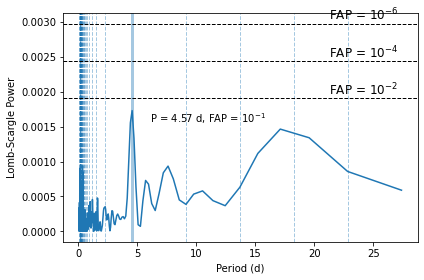

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.



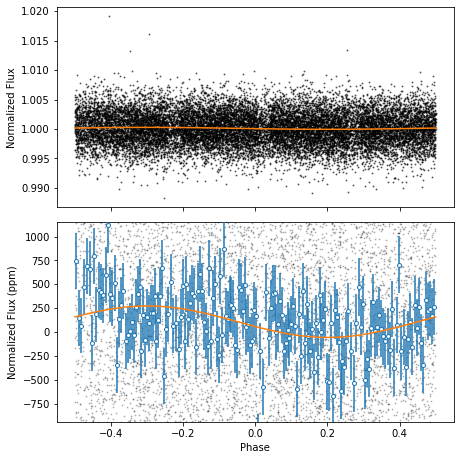

In [16]:
period, amp, fap = analyze_periodicityBR(lc_OOT1, 'WASP-96')

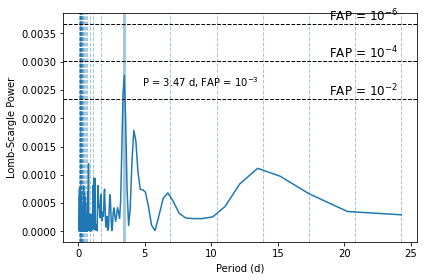

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.



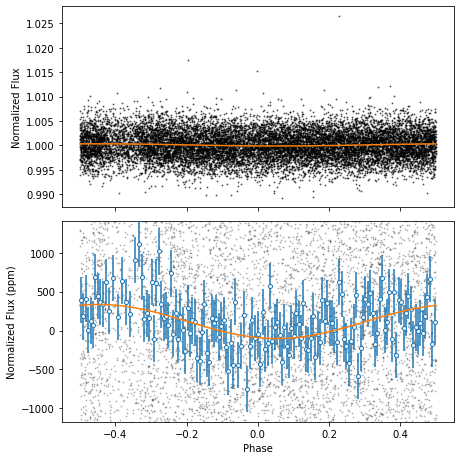

In [17]:
period, amp, fap = analyze_periodicityBR(lc_OOT2, 'WASP-96')

#### 70% sure this 12day signal that is popping up for WASP-6 is not physical, but actually due to detrending of the data
#### If you look at the reduced data, you'll see that there is a curve trend at the gaps and end of the data, which would yield around a 12 period

In [ ]:
# All planetary signals to mask
# (From https://exofop.ipac.caltech.edu/tess)
targets = [
    'WASP-25',
    'WASP-6',
    'WASP-55',
    'WASP-96',
    'WASP-124',
    'HATS-29',
]
ephemerides = {}
#P_i is the period found with no binning, no window function. 
#Tryin to see if any periods are aliases of window function
ephemerides['WASP-25'] = {
    'P_i': 6.21,
    't0': 1572.990723,
    'p': 3.764873,
    'd': 1.5*2.759996/24.    
}
ephemerides['WASP-6'] = {
    'P_i': 12.46,
    't0': 1357.394531,
    'p': 3.361021,
    'd': 1.5*2.579176/24.
}
ephemerides['WASP-55'] = {
    'P_i': 6.91,
    't0': 1573.614868,
    'p': 4.465421,
    'd': 1.5*3.480424/24.
}
ephemerides['WASP-96'] = {
    'P_i': 4.57,
    't0': 1354.319946,
    'p': 3.425239,
    'd': 1.5*2.44683/24.
}
ephemerides['WASP-124'] = {
    'P_i': 3.49,
    't0': 1327.053101,
    'p': 3.372877,
    'd': 1.5*2.63426/24.
}
ephemerides['HATS-29'] = {
    'P_i': 0.63,
    't0': 1657.83252,
    'p': 4.606184,
    'd': 1.5*3.121643/24.
}

In [ ]:
cnt = 1
Stars = len(targets)
for target in targets:
    print ("\n\n\n\n")
    print ("\033[1m ", target, "\033[0m"+str(cnt)+"/"+str(Stars))
    cnt +=1
    lc0 = get_tess_lc(target, PLOT=False)
    print ("Data time span", np.max(lc0.time) - np.min(lc0.time))
    ephem = ephemerides[target]
    lc = mask_transits(lc0, ephem['t0'], ephem['p'], ephem['d'], PLOT=False)
    print ('NO binning')
    period, amp, fap = analyze_periodicity(lc, target, 0, phyP = 0.5)
    print ('80 DP in a bin')
    period, amp, fap = analyze_periodicity(lc, target, 80, phyP = 0.5)
    print ('120 DP in a bin')
    period, amp, fap = analyze_periodicity(lc, target, 120, phyP = 0.5)
    print ('300 DP in a bin')
    period, amp, fap = analyze_periodicity(lc, target, 300, phyP = 0.5)

In [ ]:
# Loop over the targets and repeat entire procedure
sectors = []
periods = []
amps = []
faps = []

cnt = 1
Stars = len(targets)
for target in targets:
    print ("\n\n\n\n")
    print ("\033[1m ", target, "\033[0m"+str(cnt)+"/"+str(Stars))
    cnt +=1
    lc0 = get_tess_lc(target)
    ephem = ephemerides[target]
    lc = mask_transits(lc0, ephem['t0'], ephem['p'], ephem['d'])
    period, amp, fap = analyze_periodicityBR(lc, target)

    sectors.append(lc.sector)
    periods.append(period)
    amps.append(amp)
    faps.append(fap)

In [ ]:
# Save summary of results
output = pd.DataFrame({
    'target': targets,
    'sector': sectors,
    'period': periods,
    'amp': amps,
    'fap': faps
})
output

output.to_csv('twin-planets_tess-rotational-variability.csv', index=False)

# Window function test
from advice given by Chani

In [ ]:
def analyze_periodicity_Window(lc, target, error = 1.0e-10): 
    """This is B.R. code which finds periodicity using a periodagram on the original TESS data. However, now I want 
    to test if the periodicity is because of the window function. Do do that, I replace all light curve points 
    with one, but keep the timestamp."""
    # Look for any periodic variation
    lc_flux = np.ones(len(lc.time))
#     lc_flux_err = np.ones(len(lc.time))*error
    lc = lk.LightCurve(lc.time, lc_flux, lc.flux_err)
    ls = LombScargle(lc.time, lc.flux, lc.flux_err)
    frequency, power = ls.autopower(minimum_frequency=1./lc.time.ptp(),
        maximum_frequency=1./0.1)
    period = 1./frequency

    # Identify best period
    best_frequency = frequency[np.argmax(power)]
    best_period = 1./best_frequency
    fap = ls.false_alarm_probability(power.max())
    
    # Plot Lomb-Scargle results
    fig, ax = plt.subplots()

    log_probs = np.array([-2, -4, -6])
    fals = ls.false_alarm_level(10.**log_probs)

    ax.plot(period, power)
    xlim = ax.get_xlim()
    xrange = np.ptp(xlim)
    ax.axvline(best_period, alpha=0.4, lw=3)
    for n in range(2, 100):
        if n*best_period <= period.max():
            ax.axvline(n*best_period, alpha=0.4, lw=1, linestyle='--')
        if best_period/n >= period.min():
            ax.axvline(best_period/n, alpha=0.4, lw=1, linestyle='--')
    ax.text(
        best_period+0.05*xrange, power.max(), 
        f'P = {best_period:.2f} d, FAP = 10$^{{{np.log10(fap):.0f}}}$',
        va='top'
    )
    xtext = xlim[0]+0.75*xrange
    for log_prob, fal in zip(log_probs, fals):
        ax.axhline(fal, ls='--', lw=1, color='k')
        ax.text(
            xtext, fal, f'FAP = 10$^{{{log_prob}}}$',
            fontsize='12', va='bottom', transform=ax.transData
        )
    ax.set_xlabel('Period (d)')
    ax.set_ylabel('Lomb-Scargle Power')
    plt.tight_layout()
    plt.savefig(f'{target}_ls_power.pdf', bbox_inches='tight')
    plt.show()
    plt.close()    

    # Plot phase-folded light curve
    fig, axes = plt.subplots(2, figsize=(6.5, 6.5), sharex=True)
    
    phase = np.linspace(-0.5, 0.5, 100)
    phased_times = phase*best_period
    y_fit = ls.model(phased_times, best_frequency)
    amp = y_fit.ptp()

    folded_lc = lc.fold(best_period)
    binned_lc = folded_lc.bin(phase.size)

    ax = axes[0]
    ax.plot(folded_lc.time, folded_lc.flux, 'k.', ms=2, alpha=0.5, rasterized=True)
    # ax.errorbar(
    #     binned_lc.time, binned_lc.flux, binned_lc.flux_err,
    #     ls='', marker='o', mfc='white', ms=3, mew=1, zorder=10
    # )
    plt
    ax.plot(phase, y_fit, color='C1')
    ax.set_ylabel('Normalized Flux')

    flux_ppm = (folded_lc.flux-1.)*1e6
    binned_flux_ppm = (binned_lc.flux-1.)*1e6
    
#     MaxRng= folded_lc.flux #To find the max and min plotting range
#     MinRng= folded_lc.flux
    ax.set_ylim((.99, 1.01))
    binned_flux_err_ppm = (binned_lc.flux_err)*1e6
    y_fit_ppm = (y_fit-1.)*1e6
#     print ('binned_flux_ppm', binned_flux_ppm)
#     print ('type(binned_flux_ppm)', type(binned_flux_ppm))
    mad = median_abs_deviation(binned_flux_ppm) #, scale='normal') - 'normal' scale doesn't work for some reason, maybe because using py3

    ax = axes[1]
    ax.plot(folded_lc.time, flux_ppm, 'k.', ms=2, alpha=0.2, rasterized=True)
    ax.errorbar(binned_lc.time, binned_flux_ppm, binned_flux_err_ppm, ls='', marker='o', 
        mfc='white', ms=4, mew=1, zorder=10, label = 'Amp = '+str(amp*1e6)+'ppm')
    ax.plot(phase, y_fit_ppm, color='C1', zorder=11)
    plt.legend()
#     MaxRng= binned_flux_ppm+binned_flux_err_ppm #To find the max and min plotting range
#     MinRng= binned_flux_ppm-binned_flux_err_ppm
#     ax.set_ylim(np.min(MinRng), np.max(MaxRng))
    ax.set_xlabel('Phase')
    ax.set_ylabel('Normalized Flux (ppm)')

    plt.tight_layout()
    plt.savefig(f'{target}_lc_phased.pdf', dpi=600)
    plt.show()
    plt.close()
    
    return best_period, amp, fap

In [ ]:
target = 'WASP-6'
print ('\033[1m WASP6 \033[0m')
lc0 = get_tess_lc(target, PLOT = True)

t0 = 1357.394531,
p = 3.361021
d = 1.5*2.579176/24.
lc = mask_transits(lc0, t0, p, d, PLOT = True)

period, amp, fap = analyze_periodicity_Window(lc, target)
#Nothing for W6... let's see about the other 4 stars
#Also change errors to what errors my data is, so it mirrors the effect.

In [ ]:
cnt = 1
Stars = len(targets)
for target in targets:
    print ("\n\n\n\n")
    print ("\033[1m ", target, "\033[0m"+str(cnt)+"/"+str(Stars))
    cnt +=1
    lc0 = get_tess_lc(target, PLOT=False)
    print ("Data time span", np.max(lc0.time) - np.min(lc0.time))
    ephem = ephemerides[target]
    lc = mask_transits(lc0, ephem['t0'], ephem['p'], ephem['d'], PLOT=False)
    period, amp, fap = analyze_periodicity_Window(lc, target)
    print ("Aliases", np.round(period/ephem['P_i'],2))

Nothing out of the window function test. Not strong justification that the periods found are related to the window function. The shorter periods are likely found because of asymmetrical distribution and evolution of spot coverings (use information about spot size and live time coverings causing - J. Tregloan-Reed et al. 2015 - here they talkl about how the size of spots is related to it's lifetime. If there are a bunch of small spots that evolve quickly, TESS could be picking this up) and the short baseline of coverage. This is also supported by all other data. Thus, fit TESS data with strong priors.

# To correct for the stellar pulsation of HATS29
sources on pulsating stars and non-sinusoidal waves:

1) http://astronomy.swin.edu.au/sao/downloads/HET611-M17A01.pdf

2) https://www.testandmeasurementtips.com/basics-non-sinusoidal-waveforms/

3) https://en.wikipedia.org/wiki/Phase_dispersion_minimization#/media/File:RR_Lyrae,_rich_data_example.jpg

In [ ]:
HATS29 = {'t0': 1657.83252,'p': 4.606184,'d': 1.5*3.121643/24.}
target = 'HATS-29'
lc0 = get_tess_lc(target, PLOT=False)
lc = mask_transits(lc0, HATS29['t0'], HATS29['p'], HATS29['d'], PLOT=False)

# To remove outlier points
Clips, MeanMod = SigClip(lc.time, lc.flux, ReturnMod=True)
time_clean = np.delete(lc.time, Clips)
flux_clean = np.delete(lc.flux, Clips)
err_clean = np.delete(lc.flux_err, Clips)
LC = lk.LightCurve(time_clean, flux_clean, err_clean)

best_period, amp, fap = analyze_periodicity(LC, 'HATS29', 0, PLOT =False, phyP = .5) #to get period of variation
print ("best_period:", best_period)

In [ ]:
def PhaseFold(time, Flux, FluxErr, Period, PhaseNums=1): #phase equation from https://feets.readthedocs.io/en/latest/tutorial.html
    position = np.arange(Flux.size) #to get array of indeces
    t0 = time[0] # only works when t0 = 1st time series element
    diff = time-t0 
    phase = diff/(Period*PhaseNums) 
    Ceil = np.ceil(phase) #for some reason % doesn't do what it's supposed to 
    dec = phase-Ceil #so this is to properly get the decimal number of time difference over period
    PhaseFold =((dec)+1)*PhaseNums #+1 so goes from -1->0 to 0->1. Multiple by PhaseNums depending on how many phases I want to plot
    PhaseOrder = np.argsort(PhaseFold) #need to sort for fitting purposes
    Resort = np.argsort(position[PhaseOrder]) #To keep track of original order so I can convert back
    return PhaseFold[PhaseOrder], time[PhaseOrder], Flux[PhaseOrder], FluxErr[PhaseOrder], Resort #need to also keep track of the reorded time


def SigClip(time, data, thresh = 3, binSize = 100, ReturnMod = False): #To sig clip data from fitted GP model
    #thresh = number of std that will be removed
    Err = np.ones(len(data)) #errors don't matter here
    Model, Unimportant, Time  = BinDat(time, data, Err, Bin=binSize) #use the binned values to find 'model'
    FullMod = np.interp(time, Time, Model)
    std = np.std(data)
    resid = np.abs(data-FullMod)
    Outliers = np.where(resid > std*thresh)[0]
    if ReturnMod:
        return Outliers, FullMod
    else:
        return Outliers


In [ ]:
#sorting and resorting works!!!
# %matplotlib notebook
# plt.figure(figsize=(11,7))
%matplotlib inline
plt.figure(figsize=(20,10))
FoldT_phase, FoldT, FoldF, Err, sort = PhaseFold(LC.time, LC.flux, LC.flux_err, best_period, PhaseNums=3)
plt.plot(LC.time,LC.flux, markersize = 6, ls='', marker='o', mfc='white')
plt.plot(FoldT[sort], FoldF[sort],'r.')
# plt.ylim((.98,1.04))

In [ ]:
#To phase fold and bin the data
BinSize = 100
FoldT_phase, FoldT, folded_lc, flux_err, sort = PhaseFold(LC.time, LC.flux, LC.flux_err, best_period, PhaseNums=3)
BinLC, BinLCerr, BinT = BinDat(FoldT_phase, folded_lc, flux_err, Bin=BinSize)

#Need to convert to this scaling otherwise posterior doesn't make sense
mu = np.mean(folded_lc)
y = (folded_lc/mu-1)*1e3
mu = np.mean(BinLC)
y_bin = (BinLC/mu-1)*1e3
yerr = BinLCerr * 1e3 / mu
x = BinT

#Check out what I got
# %matplotlib notebook
# plt.figure(figsize=(11,7))
%matplotlib inline
plt.figure(figsize=(20,10))
plt.plot(FoldT_phase, y, 'k.', alpha = .3)
NotTim = np.zeros(len(BinT))
plt.errorbar(x, y_bin, [yerr,yerr], [NotTim,NotTim], 'r', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10)
# plt.ylim((-20,25))
plt.xlabel('Phase')
plt.ylabel('Normalized Flux (ppt)')
plt.show()
plt.close()


ploynomial fitting doesn't really work for this periodic signal. Try fitting the varibility with gaussian processes: https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/

https://www.cs.toronto.edu/~duvenaud/cookbook/

Using a periodic kernel

In [ ]:
with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    jitter = pm.Lognormal("jitter", mu=np.log(np.mean(yerr)), sd=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma("sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
    rho = pm.InverseGamma("rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0))

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma("sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
    
    period = pm.Lognormal("period", mu=np.log(1), sd=2.0) #since phase folding, period is now 1
    Q0 = pm.Lognormal("Q0", mu=0.0, sd=2.0)
    dQ = pm.Lognormal("dQ", mu=0.0, sd=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(sigma=sigma_rot, period=period, Q0=Q0, dQ=dQ, f=f)
    gp = GaussianProcess(kernel, t=x, diag=yerr ** 2 + jitter ** 2, mean=mean, quiet=True)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y_bin)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y_bin))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

In [ ]:
plt.figure(figsize=(20,10))
plt.errorbar(x, y_bin, [yerr,yerr], [NotTim,NotTim], 'r', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10)
plt.plot(BinT, map_soln["pred"],'k', label="model", linewidth = 8)
plt.ylim((-20,25))
plt.xlabel("Phase")
plt.ylabel("relative flux")
plt.title('HATS29')

In [ ]:
#To sample from the posterior
np.random.seed(10863087)
with model:
    trace = pmx.sample(
        tune=2500,
        draws=2000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
    )

In [ ]:
#convergence checks
with model:
    summary = pm.summary(
        trace,var_names=["f","dQ","Q0","period","sigma_rot","rho","sigma","jitter","mean",],)
summary

In [ ]:
# To plot the posterior distribution over rotation period
period_samples = trace["period"]
sigBck, sigFrnt = np.percentile(period_samples, 16), np.percentile(period_samples, 84)
mean = np.mean(period_samples)
Bck, Frnt = np.round(mean-sigBck, 3), np.round(sigFrnt-mean, 3)
Mean = np.round(mean, 3)
histY, histX, _ =plt.hist(period_samples, 25, histtype="step", color="k", density=True, label = str(Mean)+"+"+str(Frnt)+"-"+str(Bck))
Max = histY.max()
plt.vlines(mean,0, Max, colors='k', linestyles='--')
plt.vlines(sigBck,0, Max, colors='r', linestyles='--')
plt.vlines(sigFrnt,0, Max, colors='r', linestyles='--')
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density")
plt.legend()

In [ ]:
#Testing diffferent inference method, Autodiff Variational Inference. 
#Where we find the Gaussian approximation to the posterior that minimizes the KL divergence
np.random.seed(10863087)
with model:
    approx = pm.fit(
        n=20000,
        method="fullrank_advi",
        obj_optimizer=pm.adagrad(learning_rate=1e-1),
    )
    approx_trace = approx.sample(3000)

approx_period_samples = approx_trace["period"]
plt.hist(period_samples, 25, histtype="step", color="k", density=True, label="MCMC")
plt.hist(approx_period_samples,25,histtype="step",color="C1",linestyle="dashed",density=True,label="VI")
plt.legend()
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")

### Have a physically motivated model of the pulsation with the GP. Now to model that out and refit the periodicity

In [ ]:
#To convert the model back to the original scaling otherwise
#For binned dat
mu = np.mean(BinLC)
bin_mod = ((map_soln["pred"]/1e3)+1)*mu
#For unbinned dat
IntMap = np.interp(FoldT_phase, x, map_soln["pred"])
mu = np.mean(folded_lc)
mod = ((IntMap/1e3)+1)*mu

In [ ]:
Bin_Corr = BinLC/bin_mod
Corr = folded_lc/mod
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.plot(FoldT_phase, folded_lc, '.')
plt.plot(BinT, BinLC, '.')
plt.plot(FoldT_phase, mod)
plt.subplot(122)
plt.plot(FoldT_phase, Corr, '.') 
plt.plot(BinT, Bin_Corr, '.')
plt.show()
plt.close()
# plt.figure(figsize=(20,10))
# plt.plot(FoldT_phase, Corr, 'k.', alpha = .3)
# NotTim = np.zeros(len(BinT))
# plt.errorbar(x, Bin_Corr, [yerr,yerr], [NotTim,NotTim], 'r', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10)

In [ ]:
#To filter out regions near phase, because the residuals are so high there
#Have to do it visiually, since can only see it with binned data and have to transfer it to the unbinned data somehow
%matplotlib notebook
plt.figure(figsize=(10,7))
plt.plot(FoldT_phase, Corr, '.') 
plt.plot(BinT, Bin_Corr, '.', markersize = 10)

In [ ]:
Bads = [[0,0.373], [1.004,1.422], [2.025,2.427]]
def Filter(Flux, Time, Bads):
    for b in Bads:
        Del = np.where((b[0]<Time)&(Time<b[1]))[0]
        Time = np.delete(Time, Del)
        Flux = np.delete(Flux, Del)
    return Flux, Time
%matplotlib inline
plt.figure(figsize=(11,5))
Bin_Corr_filter, BinT_filter = Filter(Bin_Corr, BinT, Bads)
plt.plot(BinT, Bin_Corr, 'r^', markersize = 6)
plt.plot(BinT_filter, Bin_Corr_filter, 'b^', markersize = 6)
Corr_filter, T_filter = Filter(Corr, FoldT_phase, Bads)
plt.plot(FoldT_phase, Corr, 'r.')
plt.plot(T_filter, Corr_filter, 'b.')
#To also filter the array which re-sorts the array bck to sequential order
sort_filter, T_filter = Filter(sort, FoldT_phase, Bads) 

In [ ]:
#Now to convert this back to regular phase timing
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.plot(FoldT, FoldF,'r.')
plt.plot(FoldT[sort_filter], FoldF[sort_filter],'b')
plt.subplot(122)
plt.plot(FoldT, Corr,'r.')
plt.plot(FoldT[sort_filter], Corr[sort_filter],'b.')

In [ ]:
#Let's see what periodicity we will get
corr_lc = lk.LightCurve(FoldT[sort_filter], Corr[sort_filter], Err[sort_filter])
best_period, amp, fap = analyze_periodicity(corr_lc, 'HATS29_rm_pulsation', 0, PLOT =True, phyP = 6.3)

### Still get a significant period, but again it's very short compared to what I expect... Need to constrain period with other photometric data...

# attempts for polyfit, which didn't work well!!!

In [ ]:
def Checkfit(binT, binLC, binLCerr, foldedTime, foldedFlux, order): #To check what the best order poly is to fit the data
    #Try to fit the light curve with a 15th order polynomial
    coeffs = np.polyfit(binT, binLC, order, w = (1/binLCerr))
    fit = np.polyval(coeffs, binT)
    Resid = binLC-fit

    #Check out fit
    plt.plot(foldedTime, foldedFlux, 'k.', alpha = .3)
    plt.plot(binT, binLC, 'b.')
    std_resid = np.std(Resid)*1e6
    plt.plot(BinT, fit, 'r-', label = "dispersion (std) of Residuals ="+str(round(std_resid,3))+' [ppm]')
    plt.ylim((.98,1.04))
    plt.xlabel('Phase')
    plt.ylabel('Normalized Flux (ppm)')
    plt.legend()
    plt.show()
    return coeffs, std_resid


In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
# %matplotlib notebook
# plt.figure(figsize=(11,7)) #gotta make fig smaller when doing interactive, so I can fit the whole plot in one page
coeffs6, std_resid6 = Checkfit(20)
plt.close()

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
# %matplotlib notebook
# plt.figure(figsize=(11,7)) #gotta make fig smaller when doing interactive, so I can fit the whole plot in one page
coeffs7, std_resid7 = Checkfit(7)
plt.close()

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
# %matplotlib notebook
# plt.figure(figsize=(11,7)) #gotta make fig smaller when doing interactive, so I can fit the whole plot in one page
coeffs14, std_resid14 = Checkfit(14)
plt.close()

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
# %matplotlib notebook
# plt.figure(figsize=(11,7)) #gotta make fig smaller when doing interactive, so I can fit the whole plot in one page
coeffs15, std_resid15 = Checkfit(15)
plt.close()

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
# %matplotlib notebook
# plt.figure(figsize=(11,7)) #gotta make fig smaller when doing interactive, so I can fit the whole plot in one page
coeffs16, std_resid16 = Checkfit(16)
plt.close()

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
# %matplotlib notebook
# plt.figure(figsize=(11,7)) #gotta make fig smaller when doing interactive, so I can fit the whole plot in one page
coeffs17, std_resid17 = Checkfit(17)
plt.close()

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
# %matplotlib notebook
# plt.figure(figsize=(11,7)) #gotta make fig smaller when doing interactive, so I can fit the whole plot in one page
coeffs25, std_resid25 = Checkfit(25)
plt.close()

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
# %matplotlib notebook
# plt.figure(figsize=(11,7))
fit15 = np.polyval(coeffs15, BinT)
fit25 = np.polyval(coeffs25, BinT)
plt.plot(BinT, fit15-fit25, '.')
plt.show()
plt.close()

In [ ]:
#Using a 7th order polynomial to fit data, because jumping from 6th to 7th order increases the precision by two fold. 
fit7 = np.polyval(coeffs7, BinT)
puls_corrLC7 = BinLC/fit7
NotTim = np.zeros(len(BinT))
plt.errorbar(BinT, puls_corrLC7, [BinLCerr,BinLCerr], [NotTim,NotTim], 'r', markersize = 6, ls='', marker='o', mfc='white', ms=4, mew=1, zorder=10)
plt.show()
plt.close()

#Testing a 15th order polynomial to fit data, because it's a really good fit. However, afraid it's fitting more than the pulsation
fit15 = np.polyval(coeffs15, BinT)
puls_corrLC15 = BinLC/fit15
NotTim = np.zeros(len(BinT))
plt.errorbar(BinT, puls_corrLC15, [BinLCerr,BinLCerr], [NotTim,NotTim], 'r', markersize = 6, ls='', marker='o', mfc='white', ms=4, mew=1, zorder=10)
plt.show()
plt.close()


In [ ]:
#Now to fit data periodagrams to pulsation corrected LCs
#Using a 7th order polynomial to fit data, because jumping from 6th to 7th order increases the precision by two fold. 
fit7 = np.polyval(coeffs7, folded_lc.time)
puls_corrLC7 = folded_lc.flux/fit7
NotTim = np.zeros(len(lc.time))
# plt.errorbar(lc.time, puls_corrLC7, [lc.flux_err,lc.flux_err], [NotTim,NotTim], 'r', markersize = 6, ls='', marker='o', mfc='white', ms=4, mew=1, zorder=10)
plt.plot(folded_lc.time, folded_lc.flux, 'r.')
plt.show()
plt.close()

#Testing a 15th order polynomial to fit data, because it's a really good fit. However, afraid it's fitting more than the pulsation
fit15 = np.polyval(coeffs15, folded_lc.time)
puls_corrLC15 = folded_lc.flux/fit15
NotTim = np.zeros(len(folded_lc.time))
# plt.errorbar(lc.time, puls_corrLC15, [lc.flux_err,lc.flux_err], [NotTim,NotTim], 'r', markersize = 6, ls='', marker='o', mfc='white', ms=4, mew=1, zorder=10)
plt.plot(folded_lc.time, puls_corrLC7, 'r.')
plt.show()
plt.close()
